<font size ="4">**Importing all the libraries**</font>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


#additioinally imported
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

#nltk.download('all')

[nltk_data] Downloading package punkt to /home/u194134/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u194134/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/u194134/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


------------------------------------------------------------

<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [3]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip /content/News-_dataset.zip -d data/

-------------------------------------------------------------------

<font size="4">**Read the data csv file**</font>

In [4]:
fake_data = pd.read_csv('data/Fake.csv')
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true_data = pd.read_csv('data/True.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Assigning Classes to the Dataset

In [6]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [7]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

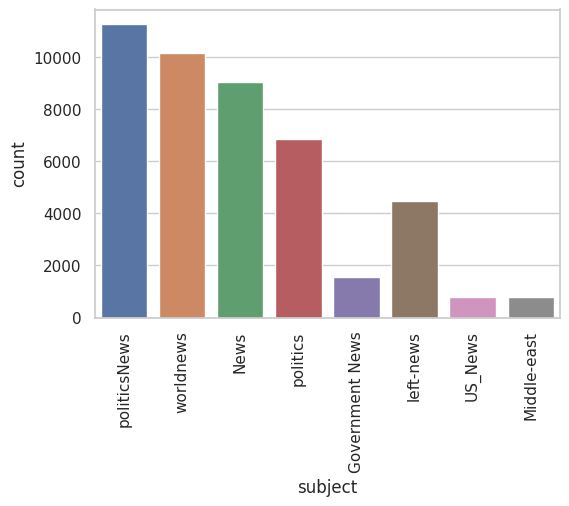

In [8]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

--------------------------------------------------------------

<font size="4">**Data preprocessing**</font>

In [9]:
data['text'] = data['title'] +' '+data['text']
del data['title']
del data['subject']
del data['date']

In [10]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [11]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [12]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [13]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,FLORIDA MOTHER Allows Baby To Be Bitten By Sna...,0
1,South Africa's Tutu asks Myanmar's Suu Kyi to ...,1
2,BOOM! KELLYANNE CONWAY Schools CNN’s Anderson ...,0
3,Catalan commission to investigate claims of ab...,1
4,Trump renews clash with U.S. sports world SOME...,1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

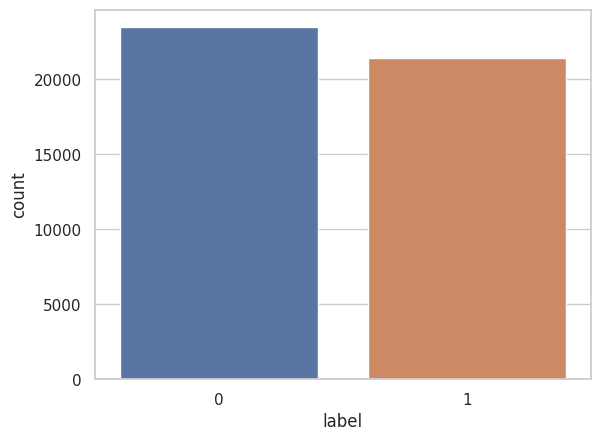

In [14]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

--------------------------------------------------------------

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [15]:
def preprocess_text(text):
    # TODO: create a function to clean your data
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

data['text'] = data['text'].apply(preprocess_text)

<font size="4">**Converting text into Vectors**</font>

In [16]:
#TODO: explore different vectorization available with sklearn.feature_extraction.text


# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the preprocessed text data
X = vectorizer.fit_transform(data['text'])

# Print the shape of the vectorized data
print("Shape of vectorized data:", X.shape)



Shape of vectorized data: (44898, 219110)


-------------------------------------------------------------

<font size="4">**Model training, Evaluation, and Prediction**</font>

In [17]:
#TODO: Model training and print the accuracy score 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

# Initialize the SVM model
model = SVC()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9942093541202672


In [18]:
# Display the Confusion matrix of Results from your classification algorithm
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[4655   28]
 [  24 4273]]


**Accuracy**: The accuracy of our model is 0.9942, indicating that it correctly classifies approximately 99.42% of the instances in the test set.

**Confusion Matrix**: The confusion matrix provides a breakdown of the predicted labels compared to the actual labels.
Here's the interpretation of the confusion matrix:

True Positives (4655): The number of instances correctly classified as "True" news.

True Negatives (4273): The number of instances correctly classified as "Fake" news.

False Positives (28): The number of instances wrongly classified as "True" news (actually "Fake" news).

False Negatives (24): The number of instances wrongly classified as "Fake" news (actually "True" news).

Overall, our model performs well with a high accuracy score of 0.9942

---------------------------------------------------------------

# Cross Validation

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

In [22]:


# Reduce the dataset size by sampling a smaller portion
sample_size = 0.2
data_sample = data.sample(frac=sample_size, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_sample['text'], data_sample['label'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the training data
X_train_vec = vectorizer.fit_transform(X_train)

# Reduce the number of folds for cross-validation
n_splits = 2
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = []
for train_index, val_index in kfold.split(X_train_vec, y_train):
    X_train_fold, X_val_fold = X_train_vec[train_index], X_train_vec[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize the SVM model
    model = SVC()

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model.predict(X_val_fold)

    # Calculate the accuracy score for the validation fold
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    cv_scores.append(accuracy_fold)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))


Cross-Validation Scores: [0.9760579064587973, 0.9774498886414253]
Mean Accuracy: 0.9767538975501113


**Cross-Validation Scores**: The list [0.9760579064587973, 0.9774498886414253] represents the accuracy scores obtained from each fold of cross-validation. These scores indicate the performance of the model on the validation data for each fold. Each score represents the proportion of correctly classified instances in the validation set. In this case, the model achieved high accuracy scores of around 0.976 to 0.977 in both folds.

**Mean Accuracy**: The mean accuracy score is calculated by taking the average of the cross-validation scores. In this case, the mean accuracy is approximately 0.977, which represents the average performance of the model across the folds. It indicates that, on average, the model correctly classified around 97.7% of the instances in the validation sets.

--------------------------------------------------------------------

# Grid Search for Hyperparameter Tuning

In [25]:
from sklearn.model_selection import GridSearchCV

In [27]:

# Initialize the SVM model
model = SVC()

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf'],
}

# Reduce the dataset size by sampling a smaller portion
sample_size = 0.2
data_sample = data.sample(frac=sample_size, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_sample['text'], data_sample['label'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the training data
X_train_vec = vectorizer.fit_transform(X_train)

# Perform cross-validation with grid search
grid_search = GridSearchCV(model, param_grid, cv=kfold)
grid_search.fit(X_train_vec, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
X_test_vec = vectorizer.transform(X_test)
y_pred = grid_search.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Best Hyperparameters: {'C': 1.0, 'kernel': 'linear'}
Test Accuracy: 0.9832962138084632


**Best Hyperparameters**: The best hyperparameters found by the grid search are C = 1.0 and kernel = 'linear'. This means that the best performing SVM model uses a regularization parameter of 1.0 and a linear kernel for classification.

**Test Accuracy**: After applying the best hyperparameters to the model, it is evaluated on the test set. The test accuracy obtained is approximately 0.9833, indicating that the model correctly classifies around 98.33% of the instances in the test set.



---------------------------------------------------------------------

# Evaluating our model's performance using other metrics

In [28]:
from sklearn.metrics import classification_report

In [30]:

# Evaluate the best model on the test set
X_test_vec = vectorizer.transform(X_test)
y_pred = grid_search.predict(X_test_vec)

# Print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       955
           1       0.98      0.99      0.98       841

    accuracy                           0.98      1796
   macro avg       0.98      0.98      0.98      1796
weighted avg       0.98      0.98      0.98      1796



**Precision**: Precision is the ratio of true positives to the sum of true positives and false positives. For class 0, the precision is 0.99, which means that out of all instances predicted as class 0, 99% are actually true negatives. For class 1, the precision is 0.98, indicating that 98% of instances predicted as class 1 are true positives.

**Recall**: Recall is the ratio of true positives to the sum of true positives and false negatives. For class 0, the recall is 0.98, which means that the model correctly identifies 98% of the actual instances of class 0. For class 1, the recall is 0.99, indicating that the model accurately detects 99% of the actual instances of class 1.

**F1-score**: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For both classes 0 and 1, the F1-scores are 0.98, indicating a good balance between precision and recall for both classes.

**Support**: Support represents the number of instances in each class. For class 0, there are 955 instances, while for class 1, there are 841 instances.

**Accuracy**: The overall accuracy of the model is 0.98, which means that it correctly classifies approximately 98% of all instances in the test set.

The classification report demonstrates that the model performs well with high precision, recall, and F1-scores for both classes. 

--------------------------------------------------------------

## ROC curve

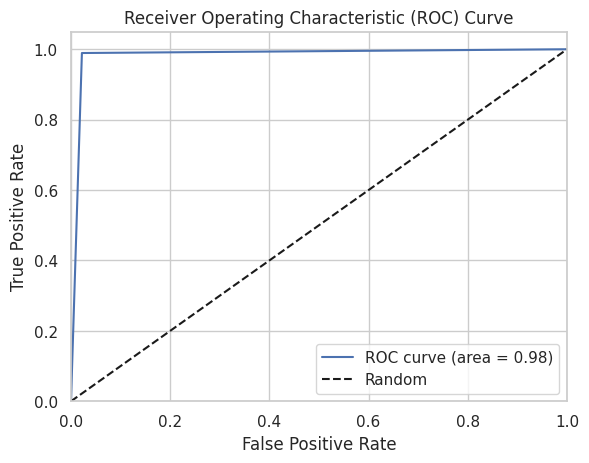

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the best model on the test set
X_test_vec = vectorizer.transform(X_test)
y_pred = grid_search.predict(X_test_vec)

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


An **AUC** of 0.98 indicates that the model has a strong true positive rate (sensitivity) and a low false positive rate (1 - specificity).

------------------------------------------------------------------------------------------------------------------------------